In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Reading datasets
df_rain = pd.read_csv("/content/Hoppers Crossing-Hourly-Rainfall.csv")
df_river = pd.read_csv("/content/Hoppers Crossing-Hourly-River-Level.csv")

# Ensure 'Date/Time' is in datetime format
df_rain['Date/Time'] = pd.to_datetime(df_rain['Date/Time'])
df_river['Date/Time'] = pd.to_datetime(df_river['Date/Time'])

# Set 'Date/Time' as index
df_rain.set_index('Date/Time', inplace=True)
df_river.set_index('Date/Time', inplace=True)

# Merge datasets on 'Date/Time'
df_combined = pd.merge(df_rain, df_river, left_index=True, right_index=True, suffixes=('_rain', '_river'))

# Check column names
print("Columns in df_combined:\n", df_combined.columns)

# Handle missing values
df_combined.fillna(df_combined.mean(), inplace=True)

# Feature engineering
df_combined['Year'] = df_combined.index.year
df_combined['Month'] = df_combined.index.month
df_combined['Day'] = df_combined.index.day
df_combined['Hour'] = df_combined.index.hour

# Features and target variable
X = df_combined[['Year', 'Month', 'Day', 'Hour', 'Cumulative rainfall (mm)']]
y = df_combined['Level (m)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Function to predict flood risk
def predict_flood_risk(rainfall_amount):
    return model.predict([rainfall_amount])[0]


Columns in df_combined:
 Index(['Current rainfall (mm)', 'Cumulative rainfall (mm)', 'Level (m)'], dtype='object')
Mean Squared Error: 0.009320123949458586


In [5]:
pip install twilio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.3 MB/s eta 0:00:00


In [15]:
import subprocess
from twilio.rest import Client
import os

# Twilio credentials
TWILIO_SID = 'ACeafea99c9ee7dcd7ab62aea5165ccd1a'
TWILIO_TOKEN = '04728c37cdb62aaf8e514cac759bec77'

# Set environment variables for phone numbers
os.environ['TO_PHONE_NUMBER'] = '+918850506017'
os.environ['FROM_PHONE_NUMBER'] = '+14804181142'

# Fetch environment variables for phone numbers
TO_PHONE_NUMBER = os.getenv('TO_PHONE_NUMBER')
FROM_PHONE_NUMBER = os.getenv('FROM_PHONE_NUMBER')

# Function to send SMS alert using Twilio API via shell command
def send_sms_alert_via_shell(to_phone_number, from_phone_number, body):
    curl_command = [
        'curl', 'https://api.twilio.com/2010-04-01/Accounts/ACeafea99c9ee7dcd7ab62aea5165ccd1a/Messages.json',
        '-X', 'POST',
        '--data-urlencode', f'To={to_phone_number}',
        '--data-urlencode', f'From={from_phone_number}',
        '--data-urlencode', f'Body={body}',
        '-u', f'{TWILIO_SID}:{TWILIO_TOKEN}'
    ]
    result = subprocess.run(curl_command, capture_output=True, text=True)
    print("Shell command output:", result.stdout)
    print("Shell command error (if any):", result.stderr)

# Function to predict flood risk
def predict_flood_risk(rainfall_amount):
    return model.predict([rainfall_amount])[0]

# Function to check flood risk and send an alert
def check_flood_risk_and_alert(rainfall_amount, model, flood_threshold, to_phone_number, from_phone_number):
    predicted_risk = predict_flood_risk(rainfall_amount)
    if predicted_risk > flood_threshold:
        message_body = f"Alert: High risk of flooding detected. Predicted river level: {predicted_risk:.2f} meters"
        send_sms_alert_via_shell(to_phone_number, from_phone_number, message_body)
    else:
        print("No flood risk detected. No alert sent.")

# Example usage --- TEST CASE---
rainfall_amount = [2018, 11, 21, 6, 50]  # Example values for Year, Month, Day, Hour, and Cumulative rainfall
flood_threshold = 1  # Example threshold in meters
check_flood_risk_and_alert(rainfall_amount, model, flood_threshold, TO_PHONE_NUMBER, FROM_PHONE_NUMBER)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Shell command output: {"account_sid": "ACeafea99c9ee7dcd7ab62aea5165ccd1a", "api_version": "2010-04-01", "body": "Sent from your Twilio trial account - Alert: High risk of flooding detected. Predicted river level: 2.35 meters", "date_created": "Thu, 05 Sep 2024 18:56:30 +0000", "date_sent": null, "date_updated": "Thu, 05 Sep 2024 18:56:30 +0000", "direction": "outbound-api", "error_code": null, "error_message": null, "from": "+14804181142", "messaging_service_sid": null, "num_media": "0", "num_segments": "1", "price": null, "price_unit": "USD", "sid": "SM7d98ee8e1a877fd63ef78a8c338db858", "status": "queued", "subresource_uris": {"media": "/2010-04-01/Accounts/ACeafea99c9ee7dcd7ab62aea5165ccd1a/Messages/SM7d98ee8e1a877fd63ef78a8c338db858/Media.json"}, "to": "+918850506017", "uri": "/2010-04-01/Accounts/ACeafea99c9ee7dcd7ab62aea5165ccd1a/Messages/SM7d98ee8e1a877fd63ef78a8c338db858.json"}
Shell command error (if any):   % Total    % Received % Xferd  Average Speed   Time    Time     Time 

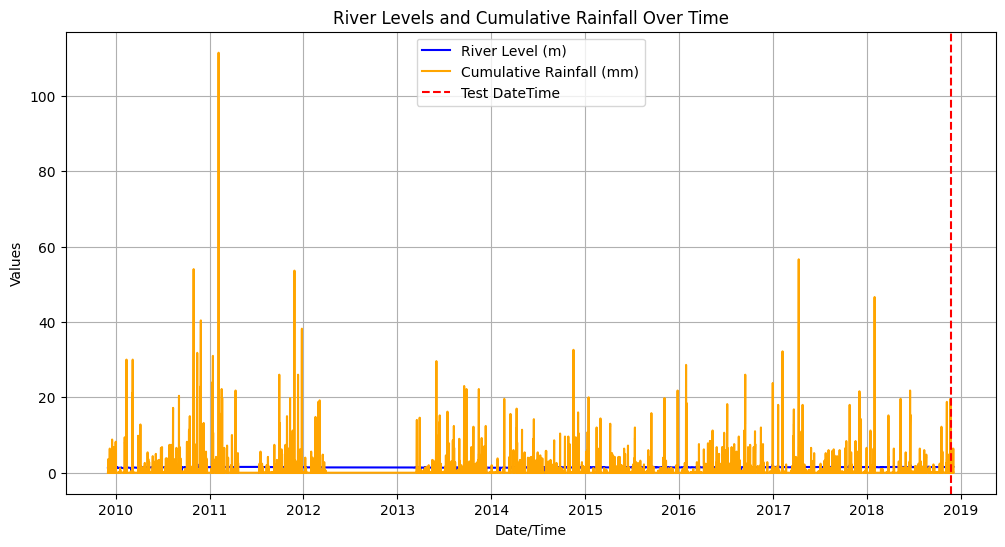

In [16]:
import matplotlib.pyplot as plt

# Plot time series of river levels and cumulative rainfall
plt.figure(figsize=(12, 6))

# Plot River Levels
plt.plot(df_combined.index, df_combined['Level (m)'], label='River Level (m)', color='blue')

# Plot Cumulative Rainfall
plt.plot(df_combined.index, df_combined['Cumulative rainfall (mm)'], label='Cumulative Rainfall (mm)', color='orange')

# Highlight the test datetime point
plt.axvline(pd.Timestamp('24-11-2018 01:00:00'), color='red', linestyle='--', label='Test DateTime')

plt.title('River Levels and Cumulative Rainfall Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'test_data' is not defined

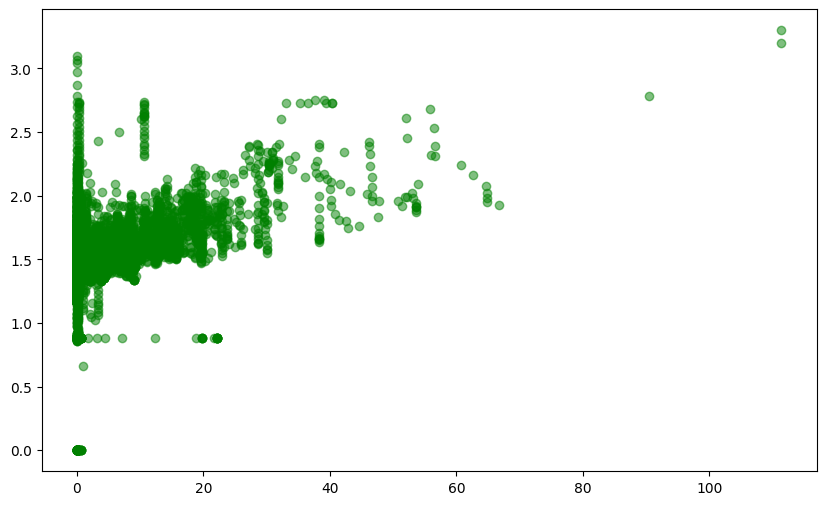

In [17]:
plt.figure(figsize=(10, 6))

# Scatter plot of Cumulative Rainfall vs. River Level
plt.scatter(df_combined['Cumulative rainfall (mm)'], df_combined['Level (m)'], alpha=0.5, color='green')

# Highlight the test data point
test_rainfall = 0  # Example rainfall value
plt.scatter(test_data['Cumulative rainfall (mm)'][0], predicted_risk, color='red', label='Test Data Point')

plt.title('Scatter Plot of Cumulative Rainfall vs. River Level')
plt.xlabel('Cumulative Rainfall (mm)')
plt.ylabel('River Level (m)')
plt.legend()
plt.grid(True)
plt.show()


TypeError: scatter() missing 1 required positional argument: 'y'

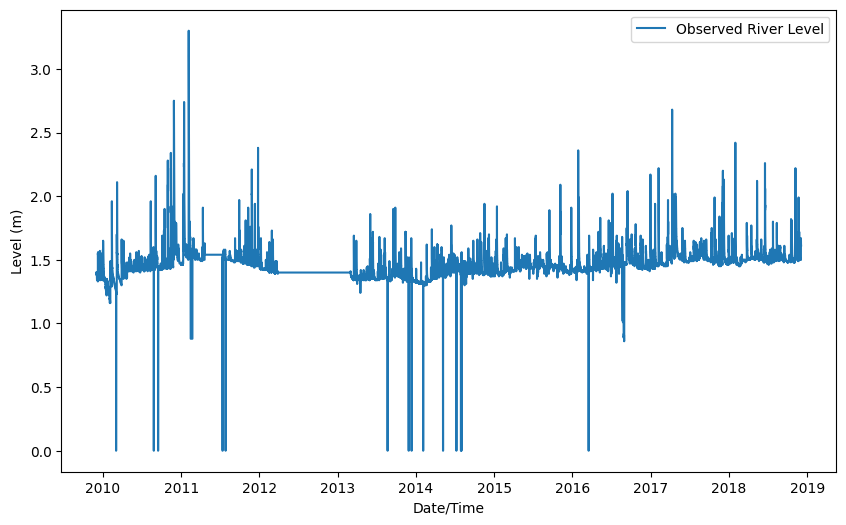

In [21]:
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plot observed data
sns.lineplot(data=df_combined, x=df_combined.index, y='Level (m)', label='Observed River Level')

# Plot predicted river level for the test datetime
plt.scatter(pd.Timestamp('24-11-2018 01:00:00'), color='red', s=100, label='Predicted Level')

plt.title('Observed vs. Predicted River Level')
plt.xlabel('Date/Time')
plt.ylabel('River Level (m)')
plt.legend()
plt.grid(True)
plt.show()
